In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('mlcourse.ai/data/sarcasm/train-balanced-sarcasm.csv')

In [3]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [5]:
train_df.dropna(subset=['comment'], inplace=True)

In [6]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [7]:
train_texts, valid_texts, y_train, y_valid = \
    train_test_split(train_df['comment'], train_df['label'],
                     random_state=17)

In [8]:
from plotly import subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
color = sns.color_palette()

In [9]:
# bar plot
cnt_srs = train_df['label'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale='Picnic',
        reversescale=True)
)


layout = go.Layout(
    title='Target Count',
    font=dict(size=18),
)


data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='TargetCount')

In [10]:
# distribution chart
labels = (np.array(cnt_srs.index))
sizes = (np.array(cnt_srs / cnt_srs.sum() * 100))


trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='TargetChart')

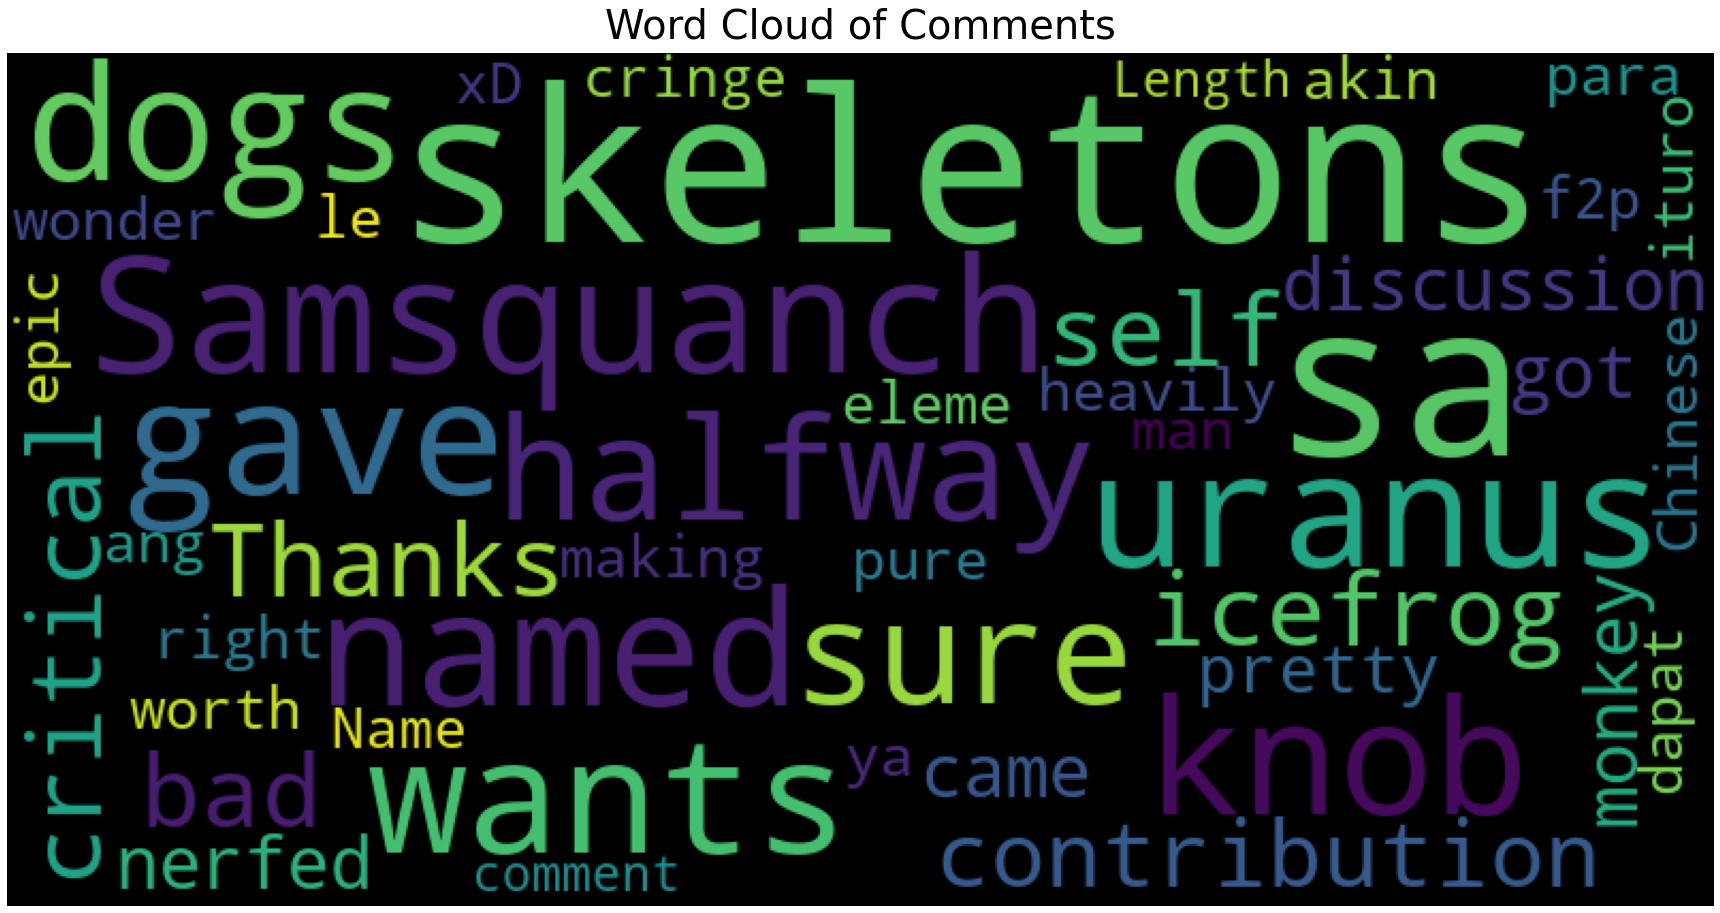

In [11]:
from wordcloud import WordCloud, STOPWORDS


def plot_wordcloud(text, mask=None, max_words=200,
                   max_font_size=100, figure_size=(24.0, 16.0),
                   title=None, title_size=40,
                   image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', 'dtype', 'object'}
    stopwords = stopwords.union(more_stopwords)
    
    wordcloud = WordCloud(background_color='black',
                         stopwords=stopwords,
                         max_words=max_words,
                         max_font_size=max_font_size,
                         random_state=42,
                         width=800,
                         height=400,
                         mask=mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors),
                   interpolation='bilinear');
        plt.title(title, fonddict={'size': title_size,
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size,
                                   'color': 'black',
                                   'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    
    
plot_wordcloud(train_texts, title='Word Cloud of Comments')

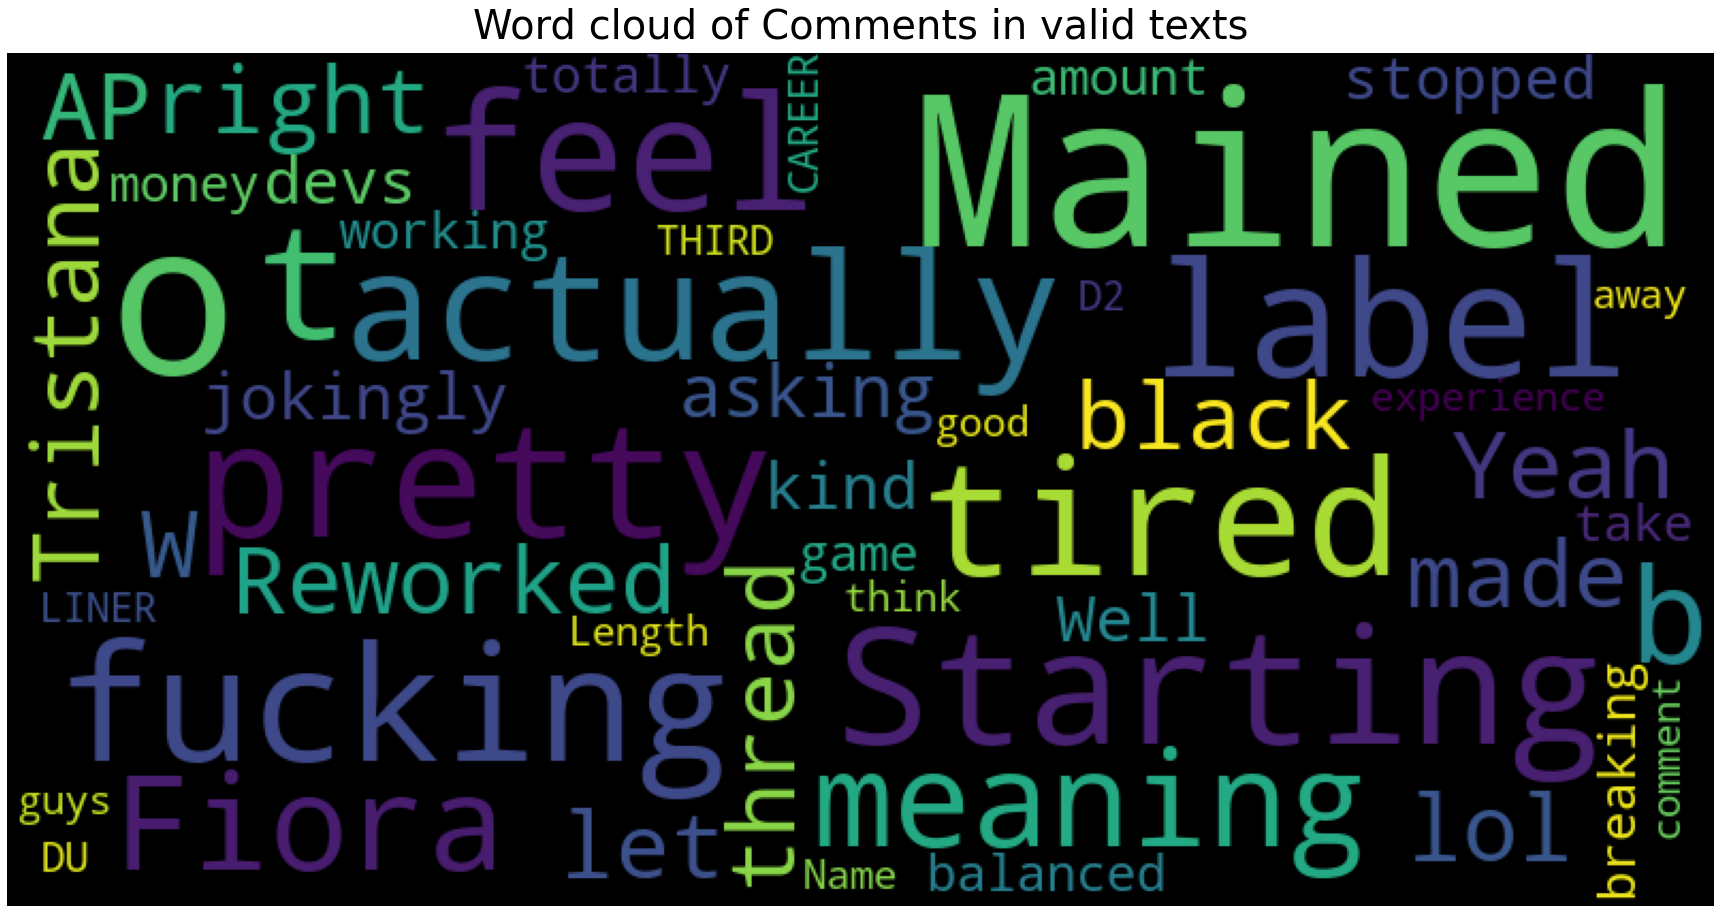

In [12]:
plot_wordcloud(valid_texts, title='Word cloud of Comments in valid texts')

In [13]:
from collections import defaultdict


train1 = train_texts[y_train == 1]
train0 = train_texts[y_train == 0]


def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ')
             if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]



def horizontal_bar_chart(df, color):
    trace=go.Bar(
        y=df['word'].values[::-1],
        x=df['wordcount'].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(color=color))
    return trace


def prepare_data(text, ngrams):
    freq_dict = defaultdict(int)
    for sent in text:
        for word in generate_ngrams(sent, ngrams):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(),
                                    key=lambda x: x[1])[::-1])
    fd_sorted.columns = ['word', 'wordcount']
    return horizontal_bar_chart(fd_sorted.head(50), 'blue')


fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=['Frequent words of sarcasm comments',
                                          'Frequent words of non-sarcasm comments'])


fig.append_trace(prepare_data(train1, 1), 1, 1)
fig.append_trace(prepare_data(train0, 1), 1, 2)
fig['layout'].update(height=1200, width=900,
                     paper_bgcolor='rgb(233,233,233)',
                     title='Word Count Plots')
py.iplot(fig, filename='word-plots')

In [14]:
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=['Frequent bigrams of sarcasm comments',
                                          'Frequent bigrams of non-sarcasm comments'])


fig.append_trace(prepare_data(train1, 2), 1, 1)
fig.append_trace(prepare_data(train0, 2), 1, 2)
fig['layout'].update(height=1200, width=900,
                     paper_bgcolor='rgb(233,233,233)',
                     title='Bigram Count Plots')
py.iplot(fig, filename='word-plots')

In [15]:
logit_pipe = Pipeline([('Tfidf', TfidfVectorizer(ngram_range=range(1, 3))), ('logit', LogisticRegression(solver='lbfgs'))])
logit_pipe.fit(train_texts, y_train)
accuracy_score(logit_pipe.predict(valid_texts), y_valid)

/home/aleksandr/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7244493339770631

In [ ]:
bag_pipe = Pipeline([('BagOfWords', CountVectorizer()),
                     ('logit', LogisticRegression(solver='lbfgs'))])
bag_pipe.fit(train_texts, y_train)
accuracy_score(bag_pipe.predict(valid_texts), y_valid)

In [ ]:
import eli5
eli5.show_weights(logit_pipe, top=20, feature_filter=lambda x: x!= '<BIAS>')

In [ ]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [ ]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

In [ ]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

In [ ]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

In [ ]:
from scipy.sparse import hstack

In [ ]:
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [ ]:
logit = LogisticRegression(C=1, solver='lbfgs', n_jobs=8, random_state=17, verbose=True)
logit.fit(X_train, y_train)

In [ ]:
valid_pred = logit.predict(X_valid)

In [ ]:
accuracy_score(y_valid, valid_pred)